In [1]:
from transformers import BertModel, BertTokenizer, AutoModel, AutoTokenizer, AutoFeatureExtractor
import torch
import pickle
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from matplotlib.patches import Patch
import pandas as pd
device = "cuda:0" if torch.cuda.is_available() else "cpu"

In [2]:
file = open('caid0.pkl', 'rb')
data0 = pickle.load(file)

In [3]:
data0 = pd.DataFrame(data0,columns=['ID','Sequence','Labels'])
data0 = data0.sample(n=300, random_state=1)
data0.to_pickle('caid300')

In [4]:
seq = data0.loc[0]['Sequence']
lab = data0.loc[0]['Labels']

In [17]:
tokenizer = AutoTokenizer.from_pretrained("./checkpoint-final/")
model = AutoModel.from_pretrained("./checkpoint-final/").eval().to(device)
pretrained = AutoModel.from_pretrained("./pretrained/").eval().to(device)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Some weights of the model checkpoint at ./checkpoint-final/ were not used when initializing RobertaModel: ['classifier.weight', 'classifier.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at ./checkpoint-final/ and are newly initialized: ['roberta.pooler.dense.weight', 

In [18]:
def get_hidden_states(encoded, model):
    with torch.no_grad():
        output = model(**encoded)
        
    # Get last hidden state
    
    return output.last_hidden_state
 
 
def get_word_vector(sent, tokenizer, model):
    encoded = tokenizer.encode_plus(sent, return_tensors="pt").to(device)
    return get_hidden_states(encoded, model)

In [19]:
sampled = data0
Xs = []
Xs_p = []
labs = []
seqs = ""
for index, row in sampled.iterrows():
    seq = row['Sequence']
    lab = list(row['Labels'])
    length = min(len(lab),1022)
    lab = lab[:length]
    seq = seq[:length]
    
    word_embedding = get_word_vector(seq, tokenizer, model)
    word_embedding = word_embedding[:,1:-1,:]
    word_embedding = np.squeeze(word_embedding.cpu().numpy())
    
    word_embedding_pre = get_word_vector(seq, tokenizer, pretrained)
    word_embedding_pre = word_embedding_pre[:,1:-1,:]
    word_embedding_pre = np.squeeze(word_embedding_pre.cpu().numpy())
    
    Xs.append(word_embedding)
    Xs_p.append(word_embedding_pre)
    seqs+=seq
    labs+=lab

In [20]:
con = np.concatenate(Xs)
con_pre = np.concatenate(Xs_p)

In [22]:
np.save('embeddings', con)
np.save('embeddings_pretrained', con_pre)
np.save('labels',np.array(labs))

In [23]:
np.array_equal(con,np.load('embeddings.npy')) and np.array_equal(con_pre,np.load('embeddings_pretrained.npy')) and np.array_equal(labs,np.load('labels.npy'))

True

In [5]:
con = np.load('embeddings.npy')
con_pre = np.load('embeddings_pretrained.npy')
labs = np.load('labels.npy')

In [10]:
X_pca = PCA(n_components=100).fit_transform(con)
X_tsne = TSNE(n_components=2, learning_rate='auto',init='random', random_state=1,n_jobs=-1).fit_transform(X_pca)

In [11]:
np.save('tsne_embeddings', X_tsne)

In [12]:
X_pca_pre = PCA(n_components=100).fit_transform(con_pre)
X_tsne_pre = TSNE(n_components=2, learning_rate='auto',init='random', random_state=1,n_jobs=-1).fit_transform(X_pca_pre)
np.save('tsne_embeddings_pretrained', X_tsne_pre)

In [6]:
X_tsne = np.load('tsne_embeddings.npy')
X_tsne_pre = np.load('tsne_embeddings_pretrained.npy')

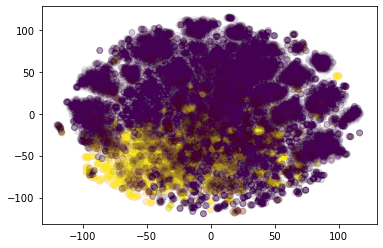

In [14]:
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=labs,alpha=0.01)

In [7]:
X_1 = PCA(n_components=1).fit_transform(con)

In [8]:
sampled = pd.read_pickle('caid300')
seqs = ""
for index, row in sampled.iterrows():
    seq = row['Sequence']
    lab = list(row['Labels'])
    length = min(len(lab),1022)
    seq = seq[:length]
    seqs+=seq

In [9]:
aas = list(set([i for i in seqs]))
per_aa_d = []
per_aa_o = []
for aa in aas:
    i_a_d = [True if a==aa and labs[i]==1 else False for i,a in enumerate(seqs)]
    i_a_o = [True if a==aa and labs[i]==0 else False for i,a in enumerate(seqs)]
    X_tsne_a_d = X_tsne[i_a_d,:]
    X_tsne_a_o = X_tsne[i_a_o,:]
    per_aa_d.append(np.mean(X_tsne_a_d, axis=0))
    per_aa_o.append(np.mean(X_tsne_a_o, axis=0))
s_per_aa_d = np.stack(per_aa_d)
s_per_aa_o = np.stack(per_aa_o)

/home/nambiar4/.conda/envs/tf/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/nambiar4/.conda/envs/tf/lib/python3.9/site-packages/numpy/core/_methods.py:180: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


posx and posy should be finite values


63

posx and posy should be finite values
posx and posy should be finite values


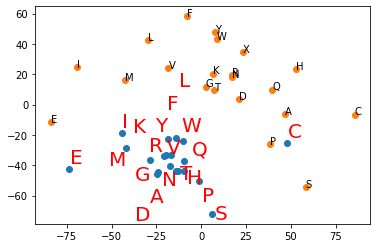

In [12]:
from adjustText import adjust_text
fig, ax = plt.subplots()
ax.scatter(s_per_aa_d[:,0],s_per_aa_d[:,1])
ax.scatter(s_per_aa_o[:,0],s_per_aa_o[:,1])
texts = [plt.text(s_per_aa_d[i,0], s_per_aa_d[i,1], txt,color='red',fontsize=20) for i, txt in enumerate(aas)]
texts2 = [plt.text(s_per_aa_o[i,0], s_per_aa_o[i,1], txt) for i, txt in enumerate(aas)]
adjust_text(texts)
#for i, txt in enumerate(aas):
 #   ax.annotate(txt, (s_per_aa_d[i,0], s_per_aa_d[i,1]))
  #  ax.annotate(txt, (s_per_aa_o[i,0], s_per_aa_o[i,1]))

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


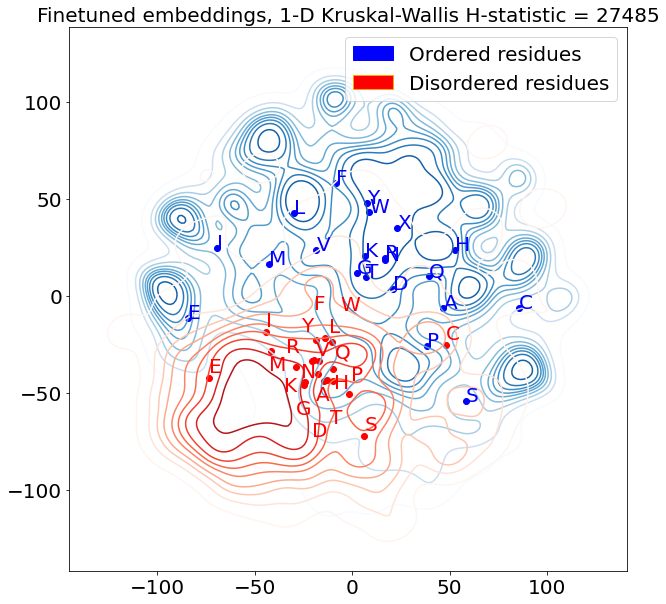

In [14]:
fig, ax = plt.subplots(figsize=(10, 10))
i_d = np.array(labs)==1
X_tsne_d = X_tsne[i_d,:]
X_1_d = X_1[i_d,:]
i_o = np.array(labs)==0
X_tsne_o = X_tsne[i_o,:]
X_1_o = X_1[i_o,:]
sns.kdeplot(x=X_tsne_o[:,0], y=X_tsne_o[:,1], cmap="Blues", shade=False, bw_adjust=1)
sns.kdeplot(x=X_tsne_d[:,0], y=X_tsne_d[:,1], cmap="Reds", shade=False, bw_adjust=1)

ax.scatter(s_per_aa_d[:,0],s_per_aa_d[:,1],c='r')
ax.scatter(s_per_aa_o[:,0],s_per_aa_o[:,1],c='b')
texts = [plt.text(s_per_aa_d[i,0], s_per_aa_d[i,1], txt,color='red',fontsize=20) for i, txt in enumerate(aas)]
texts2 = [plt.text(s_per_aa_o[i,0], s_per_aa_o[i,1], txt,color='blue',fontsize=20) for i, txt in enumerate(aas)]
adjust_text(texts)

#for i, txt in enumerate(aas):
 #   ax.annotate(txt, (s_per_aa_d[i,0], s_per_aa_d[i,1]),color='red',fontsize=20)
  #  ax.annotate(txt, (s_per_aa_o[i,0], s_per_aa_o[i,1]),color='blue',fontsize=20)

legend_elements = [Patch(facecolor='blue', edgecolor='blue',
                         label='Ordered residues'),
                  Patch(facecolor='red', edgecolor='orange',
                         label='Disordered residues')]
ax.legend(handles=legend_elements,fontsize=20)
ax.set_title('Finetuned embeddings, 1-D Kruskal-Wallis H-statistic = '+str(int(stats.kruskal(X_1_o[:,0], X_1_d[:,0])[0])),fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.savefig('res_pca_tsne_adj1_labs_v3.pdf')
plt.show()

In [7]:
X_tsne_pre = np.load('tsne_embeddings_pretrained.npy')
X_1_pre = PCA(n_components=1).fit_transform(con_pre)

In [8]:
sampled = pd.read_pickle('caid300')
seqs = ""
for index, row in sampled.iterrows():
    seq = row['Sequence']
    lab = list(row['Labels'])
    length = min(len(lab),1022)
    seq = seq[:length]
    seqs+=seq

In [9]:
aas = list(set([i for i in seqs]))
per_aa_d = []
per_aa_o = []
for aa in aas:
    i_a_d = [True if a==aa and labs[i]==1 else False for i,a in enumerate(seqs)]
    i_a_o = [True if a==aa and labs[i]==0 else False for i,a in enumerate(seqs)]
    X_tsne_a_d = X_tsne_pre[i_a_d,:]
    X_tsne_a_o = X_tsne_pre[i_a_o,:]
    per_aa_d.append(np.mean(X_tsne_a_d, axis=0))
    per_aa_o.append(np.mean(X_tsne_a_o, axis=0))

/home/nambiar4/.conda/envs/tf/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/nambiar4/.conda/envs/tf/lib/python3.9/site-packages/numpy/core/_methods.py:180: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


In [10]:
s_per_aa_d = np.stack(per_aa_d)
s_per_aa_o = np.stack(per_aa_o)

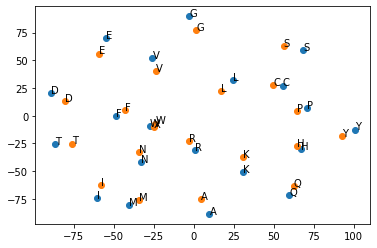

In [11]:
fig, ax = plt.subplots()
ax.scatter(s_per_aa_d[:,0],s_per_aa_d[:,1])
ax.scatter(s_per_aa_o[:,0],s_per_aa_o[:,1])

for i, txt in enumerate(aas):
    ax.annotate(txt, (s_per_aa_d[i,0], s_per_aa_d[i,1]))
    ax.annotate(txt, (s_per_aa_o[i,0], s_per_aa_o[i,1]))

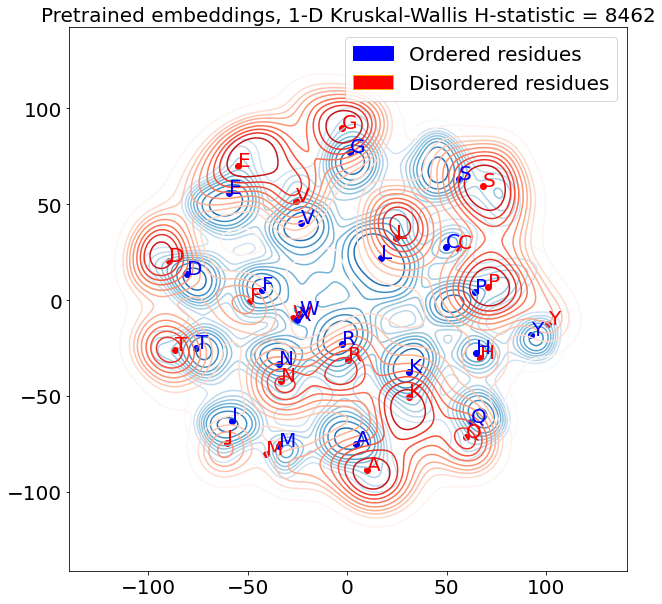

In [12]:
fig, ax = plt.subplots(figsize=(10, 10))
i_d = np.array(labs)==1
X_tsne_d = X_tsne_pre[i_d,:]
X_1_d = X_1_pre[i_d,:]
i_o = np.array(labs)==0
X_tsne_o = X_tsne_pre[i_o,:]
X_1_o = X_1_pre[i_o,:]
sns.kdeplot(x=X_tsne_o[:,0], y=X_tsne_o[:,1], cmap="Blues", shade=False, bw_adjust=1)
sns.kdeplot(x=X_tsne_d[:,0], y=X_tsne_d[:,1], cmap="Reds", shade=False, bw_adjust=1)

ax.scatter(s_per_aa_d[:,0],s_per_aa_d[:,1],c='r')
ax.scatter(s_per_aa_o[:,0],s_per_aa_o[:,1],c='b')
for i, txt in enumerate(aas):
    ax.annotate(txt, (s_per_aa_d[i,0], s_per_aa_d[i,1]),color='red',fontsize=20)
    ax.annotate(txt, (s_per_aa_o[i,0], s_per_aa_o[i,1]),color='blue',fontsize=20)


legend_elements = [Patch(facecolor='blue', edgecolor='blue',
                         label='Ordered residues'),
                  Patch(facecolor='red', edgecolor='orange',
                         label='Disordered residues')]
ax.legend(handles=legend_elements,fontsize=20)
ax.set_title('Pretrained embeddings, 1-D Kruskal-Wallis H-statistic = '+str(int(stats.kruskal(X_1_o[:,0], X_1_d[:,0])[0])), fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.savefig('res_pca_tsne_pre_adj1_v2.pdf')
plt.show()